In [1]:
# -*- coding: utf-8 -*-
#https://www.kaggle.com/ashishpatel26/beginner-tutorial-nasnet-pneumonia-detection
import keras as keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout ,GlobalAveragePooling2D,BatchNormalization
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge as NASNetLarge
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.applications import mobilenet, VGG19

import tensorflow as tf
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement=True)

#最多占gpu资源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

#开始不会给tensorflow全部gpu资源 而是按需增加
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# 資料路徑
DATASET_PATH  = 'E:/git/3rd-ML100Days/D101-103/test'

OBJECT_NAME = 'mobilenet_model_12_25-1'
# 影像大小
IMAGE_SIZE = (299, 299)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 10

# 模型輸出儲存的檔案
WEIGHTS_FINAL = OBJECT_NAME+'.h5'

# 模型輸出儲存的檔案
WEIGHTS_FINAL_BASE = 'base_'+OBJECT_NAME+'.h5'



Using TensorFlow backend.


In [2]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 2323 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [ ]:
final_model = Sequential()
final_model.add(mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)))
final_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
final_model.layers[0].trainable = False

final_model.compile(optimizer=SGD(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)


In [3]:
# 以訓練好的 NASNetLarge  為基礎來建立模型，
base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = base_model.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)
# 添加一个全连接层
# x = Dense(1024, activation='relu')(x)
# x = Dense(1024, activation='elu',name='test')(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 构建我们需要训练的完整模型
net_final = Model(inputs=base_model.input, outputs=output_layer)



# 让我们看看每一层的名字和层号，看看我们应该锁多少层呢：
for i, layer in enumerate(net_final.layers):
   print(i, layer.name)










83689472/83683744 [==============================] - 17s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 blo

In [4]:
# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型（一定要在锁层以后操作）
net_final.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 在新的数据集上训练几代
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 现在顶层应该训练好了，让我们开始微调 Inception V3 的卷积层。
# 我们会锁住底下的几层，然后训练其余的顶层。


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
145/145 [==============================] - 87s 603ms/step - loss: 6.8417 - acc: 0.5190 - val_loss: 12.9335 - val_acc: 0.1976
Epoch 2/20
145/145 [==============================] - 78s 536ms/step - loss: 4.9934 - acc: 0.6405 - val_loss: 13.2368 - val_acc: 0.1756
Epoch 3/20
145/145 [==============================] - 78s 535ms/step - loss: 4.6982 - acc: 0.6718 - val_loss: 13.3852 - val_acc: 0.1674
Epoch 4/20
145/145 [==============================] - 78s 537ms/step - loss: 4.5041 - acc: 0.6914 - val_loss: 13.3315 - val_acc: 0.1715
Epoch 5/20
145/145 [==============================] - 78s 539ms/step - loss: 4.4467 - acc: 0.6968 - val_loss: 13.2877 - val_acc: 0.1715
Epoch 6/20
145/145 [==============================] - 78s 539ms/step - loss: 4.4469 - acc: 0.6971 - val_loss: 13.0931 - val_acc: 0.1839
Epoch 7/20
145/145 [==============================] - 78s 541ms/step - loss: 4.5433 - acc

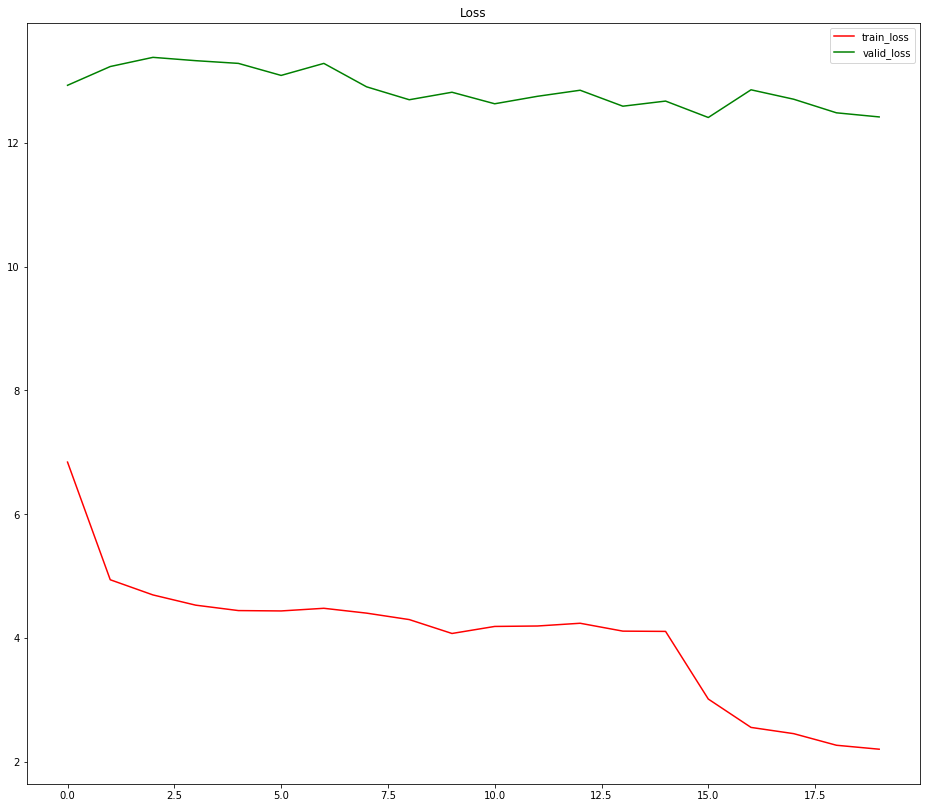

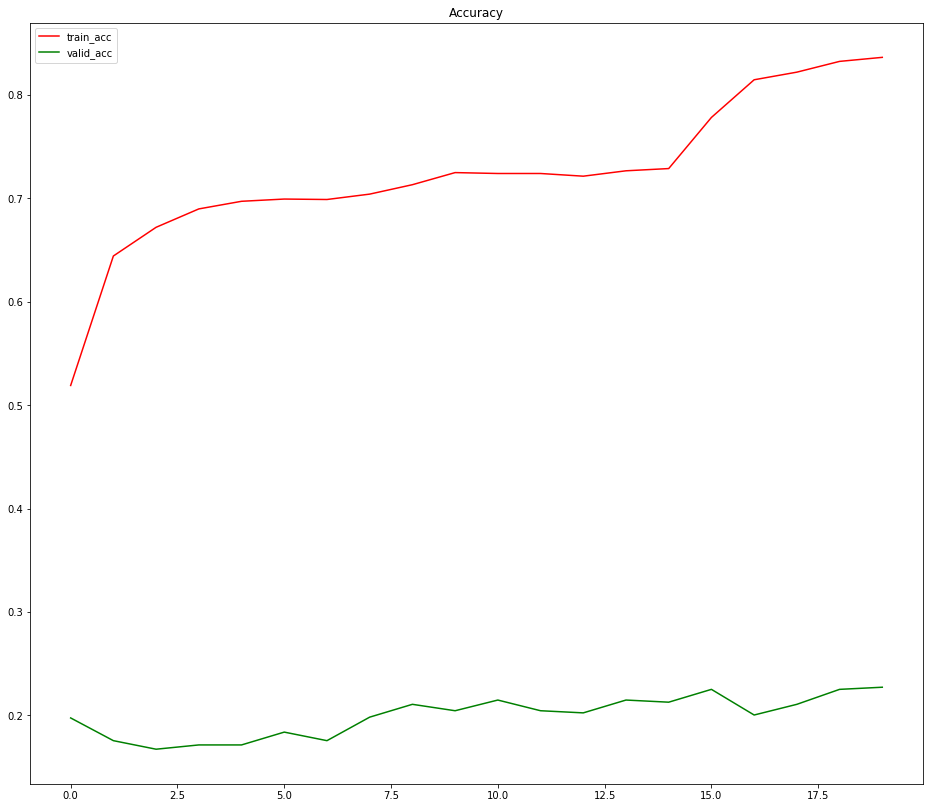

In [5]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()

In [6]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL_BASE)

In [3]:
from keras.models import load_model
net_final = load_model(WEIGHTS_FINAL_BASE)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
# 設定凍結與要進行訓練的網路層
#net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [5]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Epoch 1/20
290/290 [==============================] - 153s 526ms/step - loss: 2.1894 - acc: 0.8444 - val_loss: 2.1907 - val_acc: 0.8427
Epoch 2/20
290/290 [==============================] - 140s 483ms/step - loss: 2.0292 - acc: 0.8489 - val_loss: 1.8026 - val_acc: 0.8577
Epoch 3/20
290/290 [==============================] - 139s 480ms/step - loss: 1.6272 - acc: 0.8720 - val_loss: 1.7960 - val_acc: 0.8699
Epoch 4/20
290/290 [==============================] - 139s 480ms/step - loss: 1.6581 - acc: 0.8772 - val_loss: 1.7174 - val_acc: 0.8699
Epoch 5/20
290/290 [==============================] - 140s 481ms/step - loss: 1.7588 - acc: 0.8726 - val_loss: 1.6888 - val_acc: 0.8780
Epoch 6/20
290/290 [==============================] - 139s 478ms/step - loss: 1.4338 - acc: 0.8904 - val_loss: 1.6005 - val_acc: 0.8740
Epoch 7/20
290/290 [==============================] - 139s 478ms/step - loss: 1.4570 - acc: 0.8902 - val_loss: 1.5491 - val_acc: 0.8862
Epoch 8/20
290/290 [============================

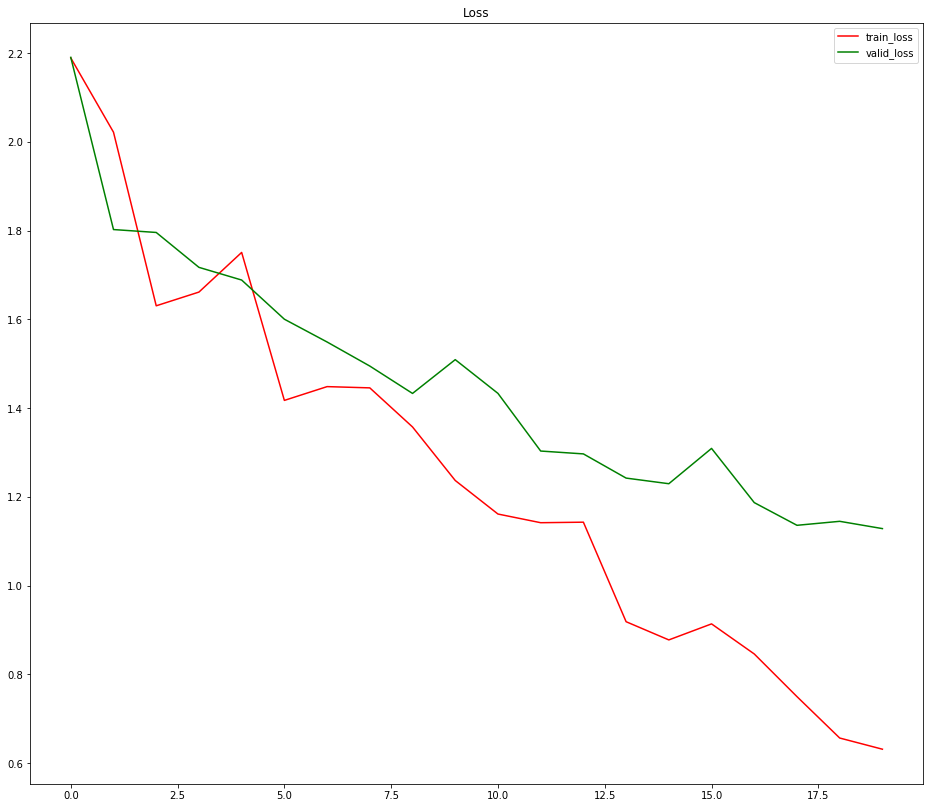

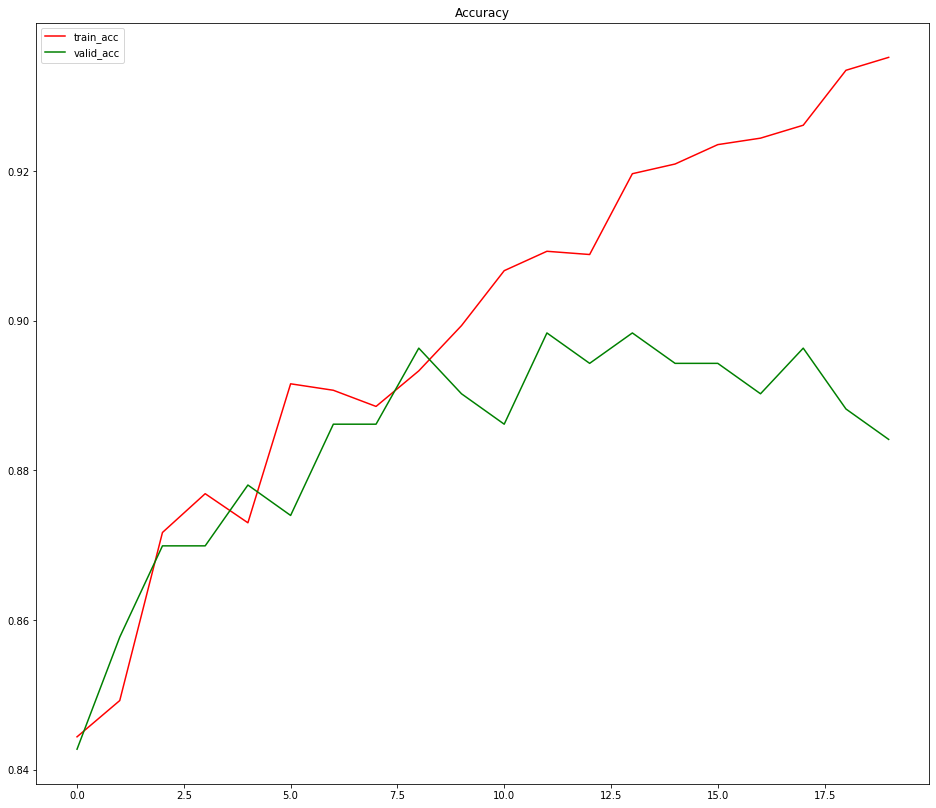

In [6]:
# Collect results
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()